<a href="https://colab.research.google.com/github/Haooo517/Generation_AI/blob/main/NTNU_41147006S_%E8%B3%87%E5%B7%A5115_%E5%BC%B5%E8%A8%93%E8%B1%AA_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STEP 1. 載入套件

首先一樣 import 老師的基本四件套 <br>
以及與神經網路相關的套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from ipywidgets import interact_manual


最後是用來展示手寫辨識的 Web app 套件 <br>
但在 import 之前要先 install

In [2]:
!pip install gradio
import gradio as gr
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


## STEP 2. 讀取 data 與 pre-process

再來先從 mnist 的 database 讀取 data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


這筆 data 總共有 60000 筆 train data / 10000 筆 test data <br>
而每筆輸入為一個 28 x 28 圖檔 <br>
內容為隨機的手寫數字 (0-9) <br>
這邊就直接用老師寫好的函式來印出資料的樣子

In [4]:
def show_xy(n=0):
    ax = plt.gca()
    X = x_train[n]
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(X, cmap = 'Greys')
    print(f'數字: {y_train[n]}')

interact_manual(show_xy, n=(0,59999));

interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

不過由於標準神經網路無法讀取矩陣型態的資料 <br>
因此先將資料轉成一維向量 <br>
使用 `reshape()` 函式轉換資料

In [5]:
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

接著需要對這些輸出進行分類運算 <br>
因為 0-9 的數字對程式來說是有序的 <br>
所以要使用 one-hot encoding 來讓這些數字失去連續性


In [6]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## STEP 3. 建立神經網路

這裡使用的模型是標準的 `Sequential()` 神經網路 <br>
允許我們一層一層地順序疊加神經網路

In [7]:
model = Sequential()

接著就開始建立第一層神經網路 <br>
各種設定說明如下： <br>
- `model.add(Dense(512, input_dim=784))`
    - `Dense(512)`：建立 512 個神經元的全連接層
    - `input_dim=784`：輸入層的特徵數量是 784 (28 x 28)
- `LeakyReLU(negative_slope=0.1)`
    - 老師的範本使用的是 ReLU ，是一種常用的激活函數
    - 但它有一個問題：當輸入值為負時，它的輸出永遠是 0，可能會導致某些神經元完全不更新權重（神經元死亡）
    - LeakyReLU 改進了 ReLU，它在負數區域允許一點小的梯度（α=0.1），
這樣可以避免神經元死亡，讓梯度仍能流動
- `BatchNormalization()`
    - 加速訓練：讓不同特徵的數值範圍變得更穩定
    - 減少 Overfitting：讓神經網路不會因為輸入值的變化過大而學習不穩定
    - 讓神經網路更容易收斂

In [8]:
model.add(Dense(512, input_dim=784))
model.add(LeakyReLU(negative_slope=0.1))
model.add(BatchNormalization())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- `model.add(Dense(384))`
    - `Dense(384)`：建立 384 個神經元，負責從前一層提取的特徵中學習更深層的模式
- `Dropout(0.3)`
    - Dropout 是一種 正則化技術，作用是隨機讓 30% 的神經元在訓練時不更新權重
    - 防止 Overfitting，讓神經網路不會太依賴特定的神經元，而是學習更泛化的特徵

In [9]:
model.add(Dense(384))
model.add(LeakyReLU(negative_slope=0.1))
model.add(Dropout(0.3))

總共建立了五層神經網路 <br>
並逐層減少神經元數量（512 → 384 → 256 → 128 → 64）<br>
這種方式可以幫助壓縮資訊並學習更高層次的特徵 <br>
同時在適當位置加入 `BatchNormalization()` 和 `Dropout(0.3)` <br>
提高穩定性並減少 Overfitting

In [10]:
model.add(Dense(256))
model.add(LeakyReLU(negative_slope=0.1))
model.add(BatchNormalization())

In [11]:
model.add(Dense(128))
model.add(LeakyReLU(negative_slope=0.1))
model.add(Dropout(0.3))

In [12]:
model.add(Dense(64))
model.add(LeakyReLU(negative_slope=0.1))
model.add(BatchNormalization())

最後建立輸出層 <br>
只需要對應數字 0-9 的 10 個神經元即可 <br>
並且使用 softmax 函數將每個數字的輸出結果轉成機率分佈

In [13]:
model.add(Dense(10, activation='softmax'))

接下來就是要編譯它了 <br>
我選擇的參數如下：
- `loss='categorical_crossentropy'`：適用於多類別分類問題 <br>
不使用 mse 是因為其較適合迴歸問題，但在分類問題中，使用交叉熵能夠更有效地計算預測機率分佈與真實標籤之間的距離，讓模型更快收斂
- `optimizer=Adam(learning_rate=0.001)`：比老師選擇的傳統優化器 SGD 更有效率
- `metrics=['accuracy']`：使用 accuracy 作為評估指標

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

最後就是來檢視一下建立好的神經網路 <br>
是否跟設定都相同

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 384)                 │         196,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 742,602 (2.83 MB)

 Trainable params: 740,938 (2.83 MB)

 Non-trainable params: 1,664 (6.50 KB)

## STEP 4. 開始訓練

終於進入了訓練模型的環節 <br>
先設定 `batch_size` 為中規中矩的 128 <br>
而由於前面有使用 `Dropout()` 減少了 Overfitting 的風險 <br>
就把 `epoch` 設定在高一點的值看看

In [16]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8383 - loss: 0.5380 - val_accuracy: 0.9600 - val_loss: 0.1305
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9573 - loss: 0.1423 - val_accuracy: 0.9683 - val_loss: 0.1074
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9695 - loss: 0.0987 - val_accuracy: 0.9725 - val_loss: 0.0944
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9763 - loss: 0.0773 - val_accuracy: 0.9741 - val_loss: 0.0921
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9792 - loss: 0.0652 - val_accuracy: 0.9753 - val_loss: 0.0788
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9829 - loss: 0.0565 - val_accuracy: 0.9766 - val_loss: 0.0834
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9849 - loss: 0.0492 - val_accuracy: 0.9772 - val_loss: 0.0832
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9862 - loss: 0.0431 - val_accuracy: 0

訓練完就將成果印出來看看

In [17]:
loss, acc = model.evaluate(x_test, y_test)
print(f"測試資料正確率: {acc * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9787 - loss: 0.0933
測試資料正確率: 98.10%


為了讓訓練過程更加明瞭 <br>
這邊使用 plt 來把訓練過程給視覺化

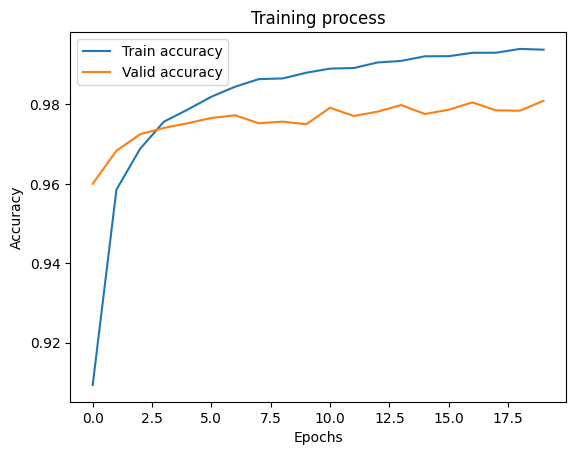

In [18]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Valid accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training process')
plt.show()

## STEP 6. 酷酷的 Gradio

最後就來用 gradio <br>
看看訓練出來的 AI 對我自己手寫的字 <br>
判斷的表現如何

In [ ]:
def resize_image(inp):
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)
    image_pil = Image.fromarray(image)
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3])
    image_pil = background
    image_gray = image_pil.convert("L")
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))
    img_array = 255 - img_array
    img_array = img_array.reshape(1, 784) / 255.0
    return img_array


def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字，系統將進行辨識。"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d02e62d8570bd89319.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
